In [50]:
!pip install yfinance
from statsmodels.stats.diagnostic import het_white
import warnings
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas_datareader as pdr
import datetime as dt
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

warnings.filterwarnings("ignore")
#%matplotlib notebook

# Extraction And Processing Of Data

stocks

We have scrapped monthly data of the above mentioned stocks and the BSESN market index 2017-10-21 onwards from yahoo finance

In [51]:
tickers = ['ADANIPORTS.BO', 'MRF.BO', 'TCS.BO', 'RELIANCE.BO', 'HDFC.BO','DRREDDY.BO','^BSESN']



n=len(tickers)-1

#data = yf.download(tickers, 
#                      start='2017-10-21',
#)

data = yf.download(tickers, 
                      start='2017-10-21',
                      progress=False,interval ='1mo'
)

The close prices are extracted

In [52]:
data = data['Adj Close']
data.head()


,ADANIPORTS.BO,DRREDDY.BO,HDFC.BO,MRF.BO,RELIANCE.BO,TCS.BO,^BSESN
Date,,,,,,,
2017-11-01,386.889496,2184.841553,1562.830200,68160.656250,902.951782,1203.015015,33149.351562
2017-12-01,392.515533,2307.206543,1593.149170,71860.390625,901.434753,1233.224609,34056.828125
2018-01-01,415.601868,2126.454102,1821.633057,68103.632812,940.680786,1421.080811,35965.019531
2018-02-01,396.007599,2136.392578,1690.345703,72890.703125,932.166077,1390.809570,34184.039062
2018-03-01,344.014923,1989.994019,1699.333984,71816.320312,863.999329,1304.314697,32968.679688




Log returns are used instead of arithmetic returns, for many of the use cases they are almost the same,but most technical analyses require detrending/normalizing the time series and using log returns is a nice way to do that.
Log returns are convenient to work with in many of the algorithms we will encounter.


In [53]:
log_returns = np.log(data/data.shift())
log_returns.head()

,ADANIPORTS.BO,DRREDDY.BO,HDFC.BO,MRF.BO,RELIANCE.BO,TCS.BO,^BSESN
Date,,,,,,,
2017-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.014437,0.054494,0.019214,0.052858,-0.001681,0.024801,0.027007
2018-01-01,0.057152,-0.081582,0.134021,-0.053695,0.042616,0.141785,0.054516
2018-02-01,-0.048294,0.004663,-0.074800,0.067931,-0.009093,-0.021532,-0.050788
2018-03-01,-0.140748,-0.070987,0.005303,-0.014849,-0.075939,-0.064208,-0.036201


Since we had collected monthly data, we annualize the mean return and covariance matrix of log returns by multiplying 12

In [54]:
annual_exp_ret = log_returns.mean() * 12
annual_exp_ret

ADANIPORTS.BO    0.145744
DRREDDY.BO       0.136909
HDFC.BO          0.082030
MRF.BO           0.046884
RELIANCE.BO      0.201419
TCS.BO           0.191840
^BSESN           0.116341
dtype: float64

In [55]:
annual_cov_matrix=log_returns.cov()*12
annual_cov_matrix

,ADANIPORTS.BO,DRREDDY.BO,HDFC.BO,MRF.BO,RELIANCE.BO,TCS.BO,^BSESN
ADANIPORTS.BO,0.116693,-0.002307,0.050754,0.039826,0.041869,0.017849,0.048266
DRREDDY.BO,-0.002307,0.067875,0.001269,-0.009989,0.029553,0.014737,0.005900
HDFC.BO,0.050754,0.001269,0.072862,0.027562,0.033558,0.024142,0.045175
MRF.BO,0.039826,-0.009989,0.027562,0.057529,0.007389,0.003785,0.020693
RELIANCE.BO,0.041869,0.029553,0.033558,0.007389,0.086380,0.031952,0.038266
TCS.BO,0.017849,0.014737,0.024142,0.003785,0.031952,0.056760,0.022762
^BSESN,0.048266,0.005900,0.045175,0.020693,0.038266,0.022762,0.038874


# Defining functions and variables for Calculation of Beta

here we initialize the dataframes for

1.   alpha of stock
2.   beta of stock
3.   r-squared
4.   statistics of residue
5.   white's test statistics




In [56]:
alpha_df=pd.Series()
beta_df=pd.Series()
rsq_df=pd.Series()
stats_df=pd.DataFrame()
whitetest_df=pd.DataFrame()


linear regression function to calculate beta of a stock

In [57]:
def linear_regression(ticker_a, ticker_b):
    df=log_returns[[ticker_a,ticker_b]]
    df=df.dropna()
    x = df[ticker_b]
    y = df[ticker_a]
    x_sm = sm.add_constant(x)

    model = sm.OLS(y,x_sm)
    results = model.fit()
    #print("r square score of "+ticker_a+": "+str(lin_regr.score(X,Y)))
    
    #Y_pred = lin_regr.predict(X)

    alpha = results.params[0]
    alpha_df[ticker_a]=alpha
    beta = results.params[1]
    beta_df[ticker_a]=beta
    rsq_df[ticker_a]=results.rsquared

    stats_df[ticker_a]=results.resid.describe()

    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.set_figheight(12)
    fig.set_figwidth(60)

    sns.regplot(x = ticker_b, y = ticker_a, data = log_returns, ax=ax[0])
    #ax1.set_title(ticker_a+ "- Alpha: " + str(round(alpha, 5)) + ", Beta: " + str(round(beta, 3)))
    #ax1.scatter(X, Y)
    #ax1.plot(X, Y_pred, c='r')
    sns.distplot(results.resid, ax=ax[1])
    sm.qqplot(results.resid,line='45',fit=True,dist=stats.norm, ax=ax[2])

    #stats_df.append()


    #Checking for Homoskedasticity of errors (Assumption requirement of linear regression)
    #perform White's test
    white_test = het_white(results.resid,  results.model.exog)
    whitetest_df[ticker_a]=white_test


# Generating beta of stocks and other statistics of linear regression 


------betas------
ADANIPORTS.BO    1.241589
MRF.BO           0.532302
TCS.BO           0.585539
RELIANCE.BO      0.984354
HDFC.BO          1.162069
DRREDDY.BO       0.151769
dtype: float64

------r squared scores------
ADANIPORTS.BO    0.513541
MRF.BO           0.191465
TCS.BO           0.234817
RELIANCE.BO      0.436067
HDFC.BO          0.720481
DRREDDY.BO       0.013192
dtype: float64

------residue analysis------
       ADANIPORTS.BO        MRF.BO        TCS.BO   RELIANCE.BO       HDFC.BO  \
count   6.000000e+01  6.000000e+01  6.000000e+01  6.000000e+01  6.000000e+01   
mean   -5.030698e-18 -2.616541e-18 -1.351639e-17 -1.170938e-17 -1.619075e-18   
std     6.877878e-02  6.225915e-02  6.016084e-02  6.371325e-02  4.119709e-02   
min    -1.802302e-01 -1.355370e-01 -1.169407e-01 -1.764649e-01 -1.281195e-01   
25%    -3.895495e-02 -3.519422e-02 -4.647565e-02 -4.272877e-02 -2.596201e-02   
50%    -8.237016e-04 -5.267030e-03 -4.126328e-03  4.508694e-03 -7.266583e-03   
75%     3.612349e-0

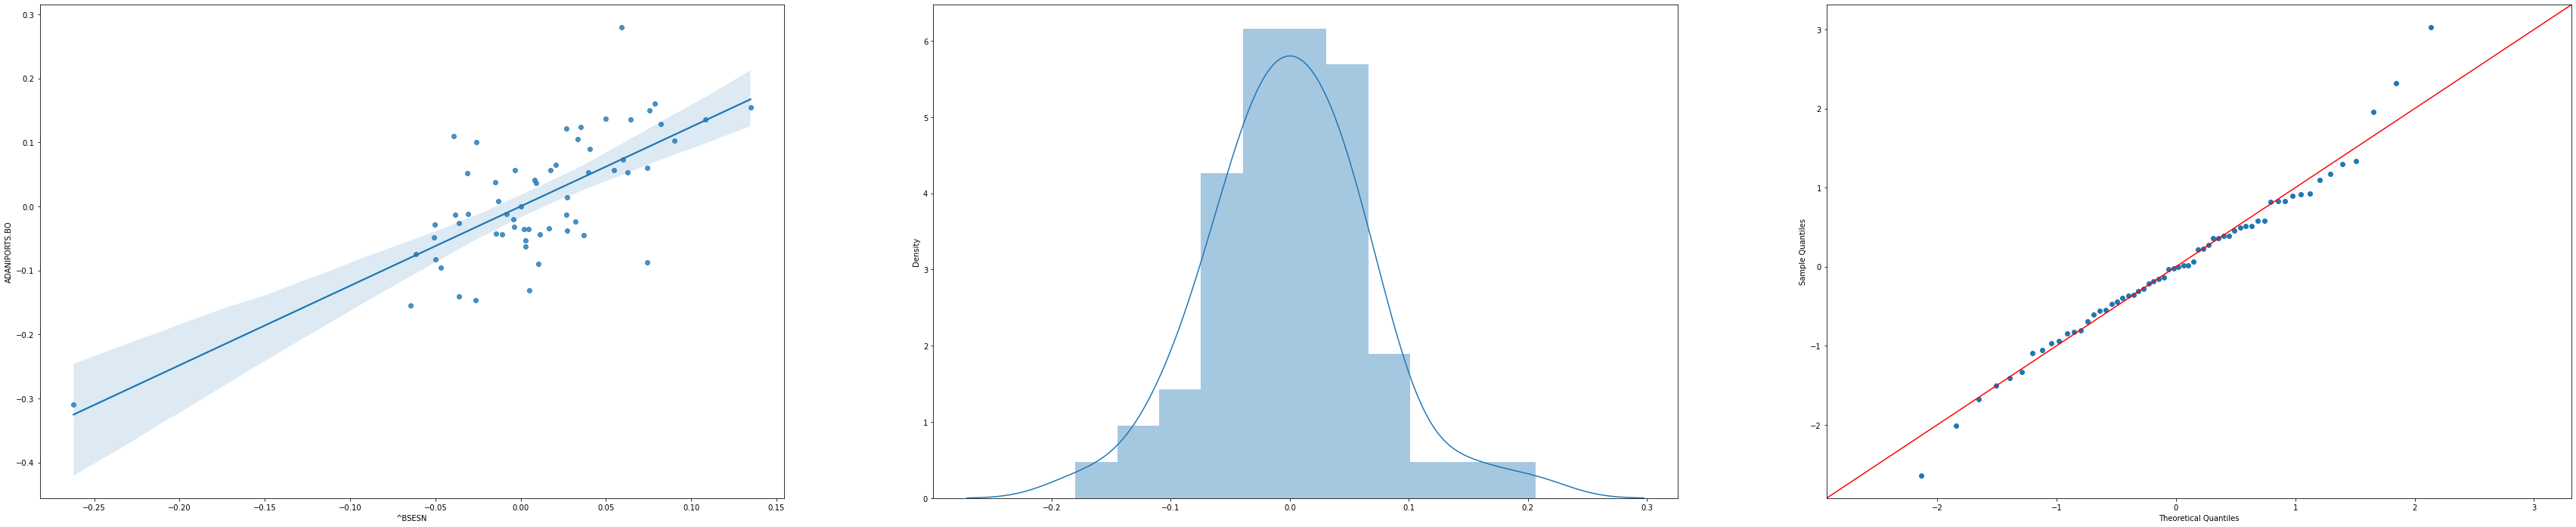

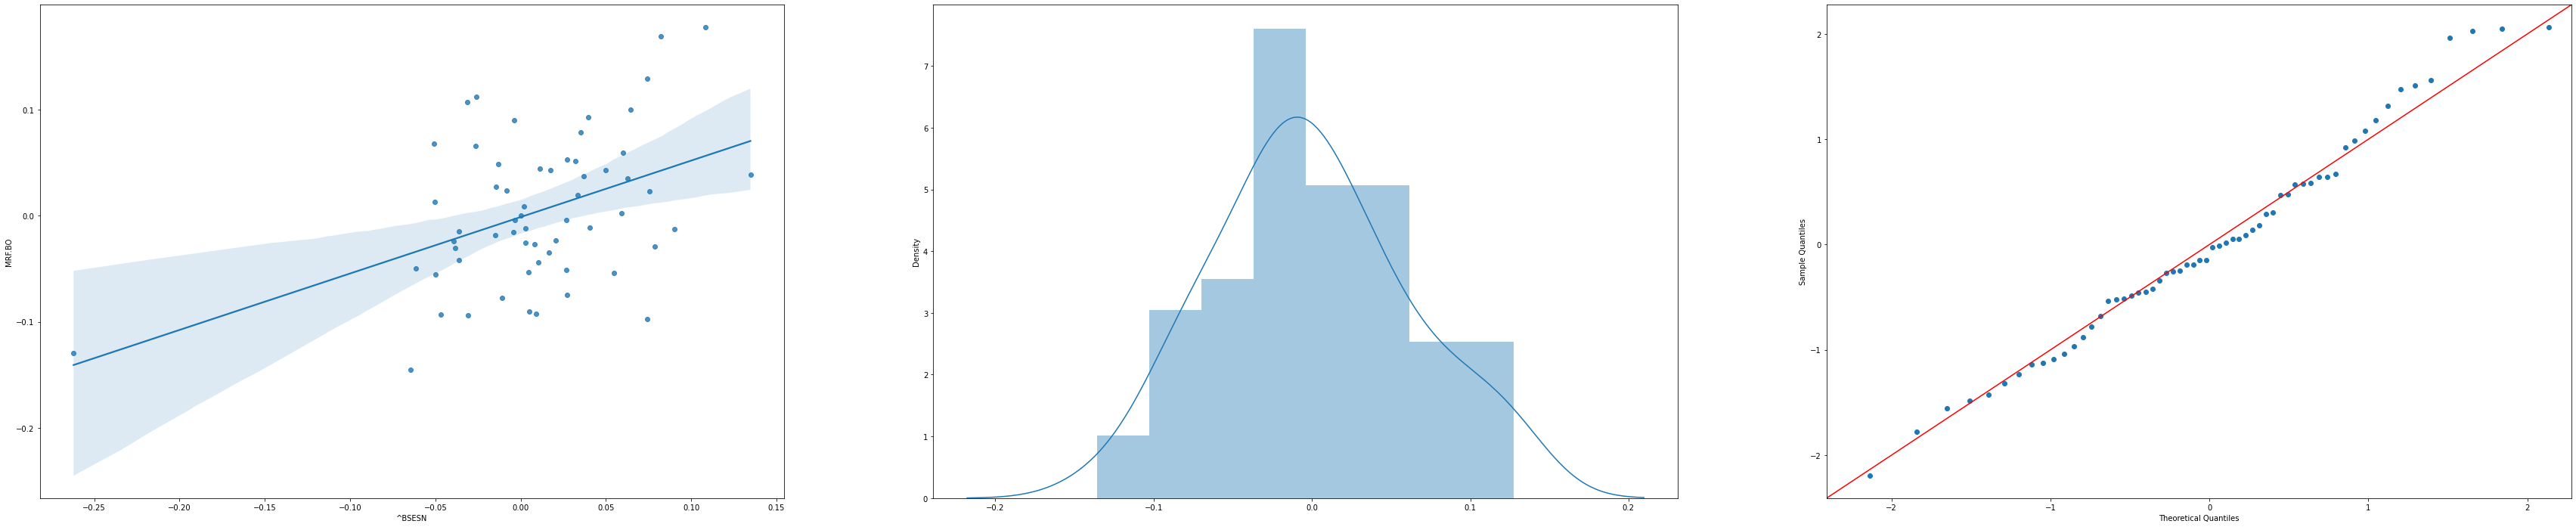

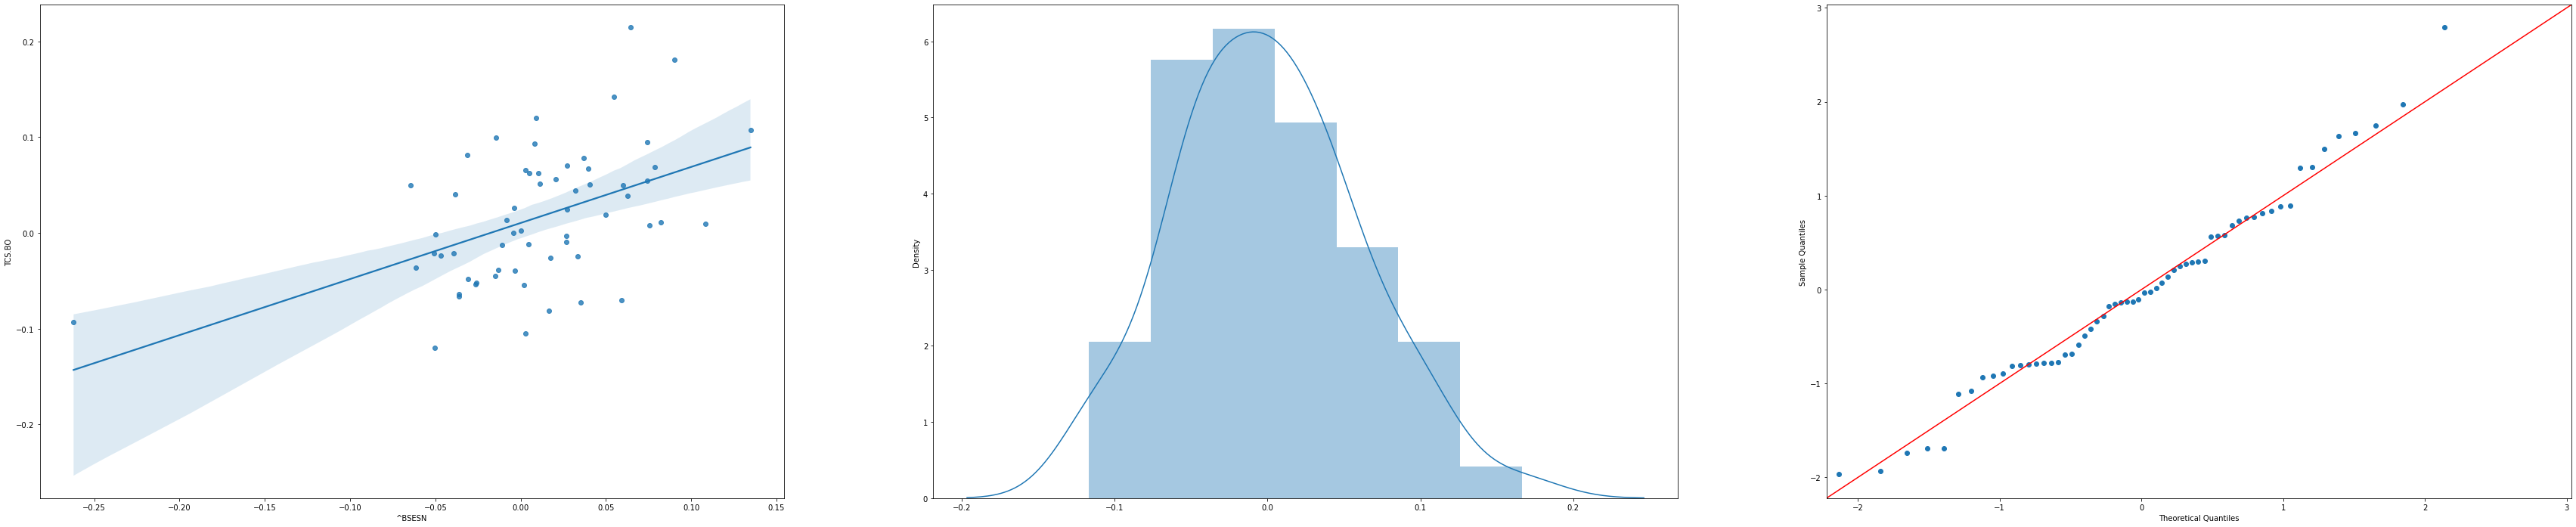

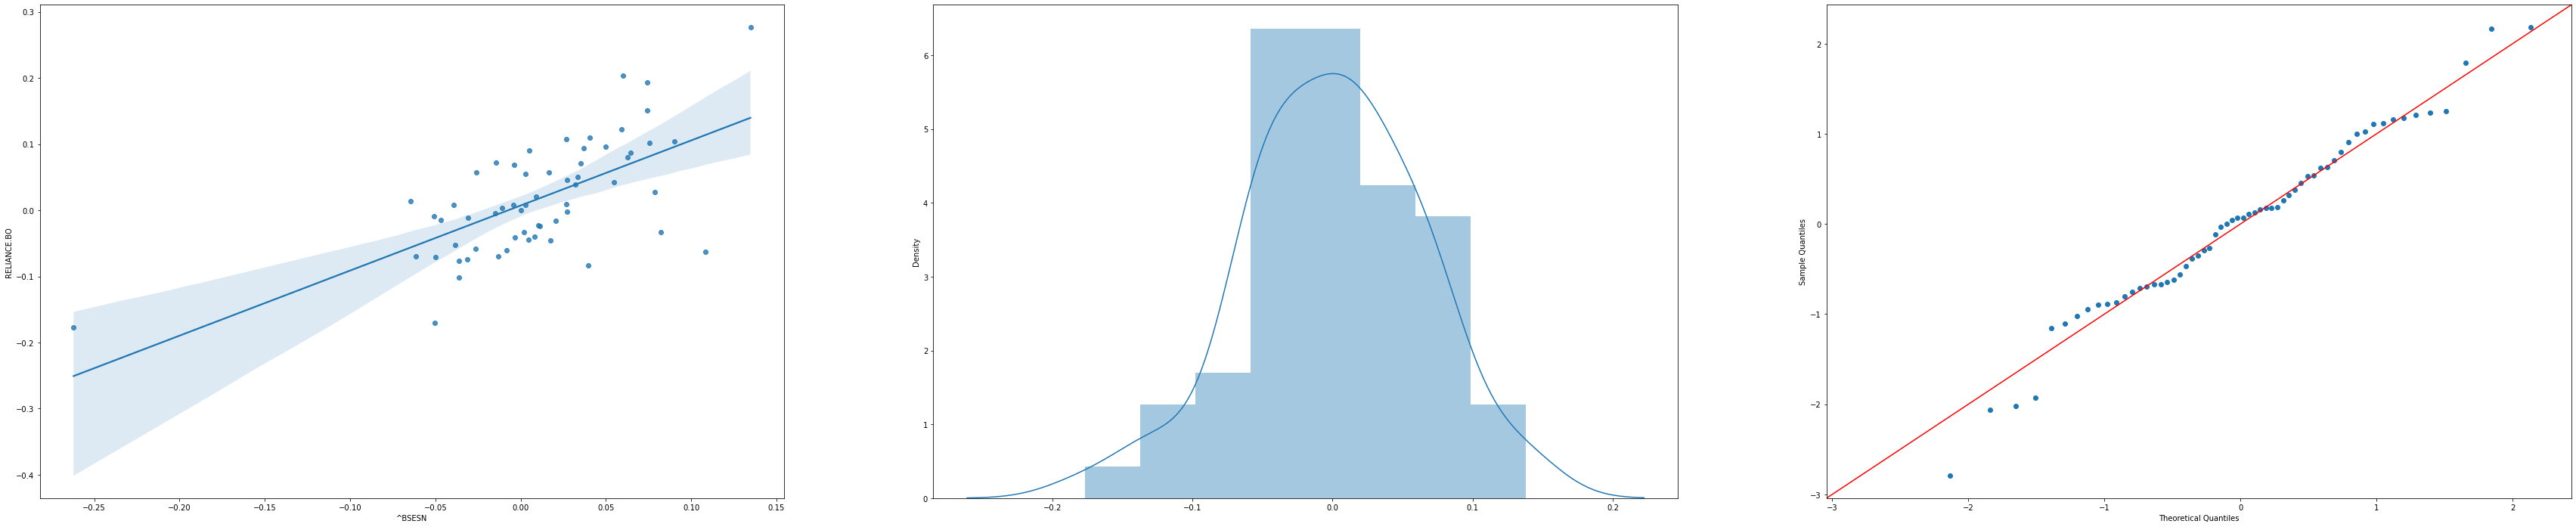

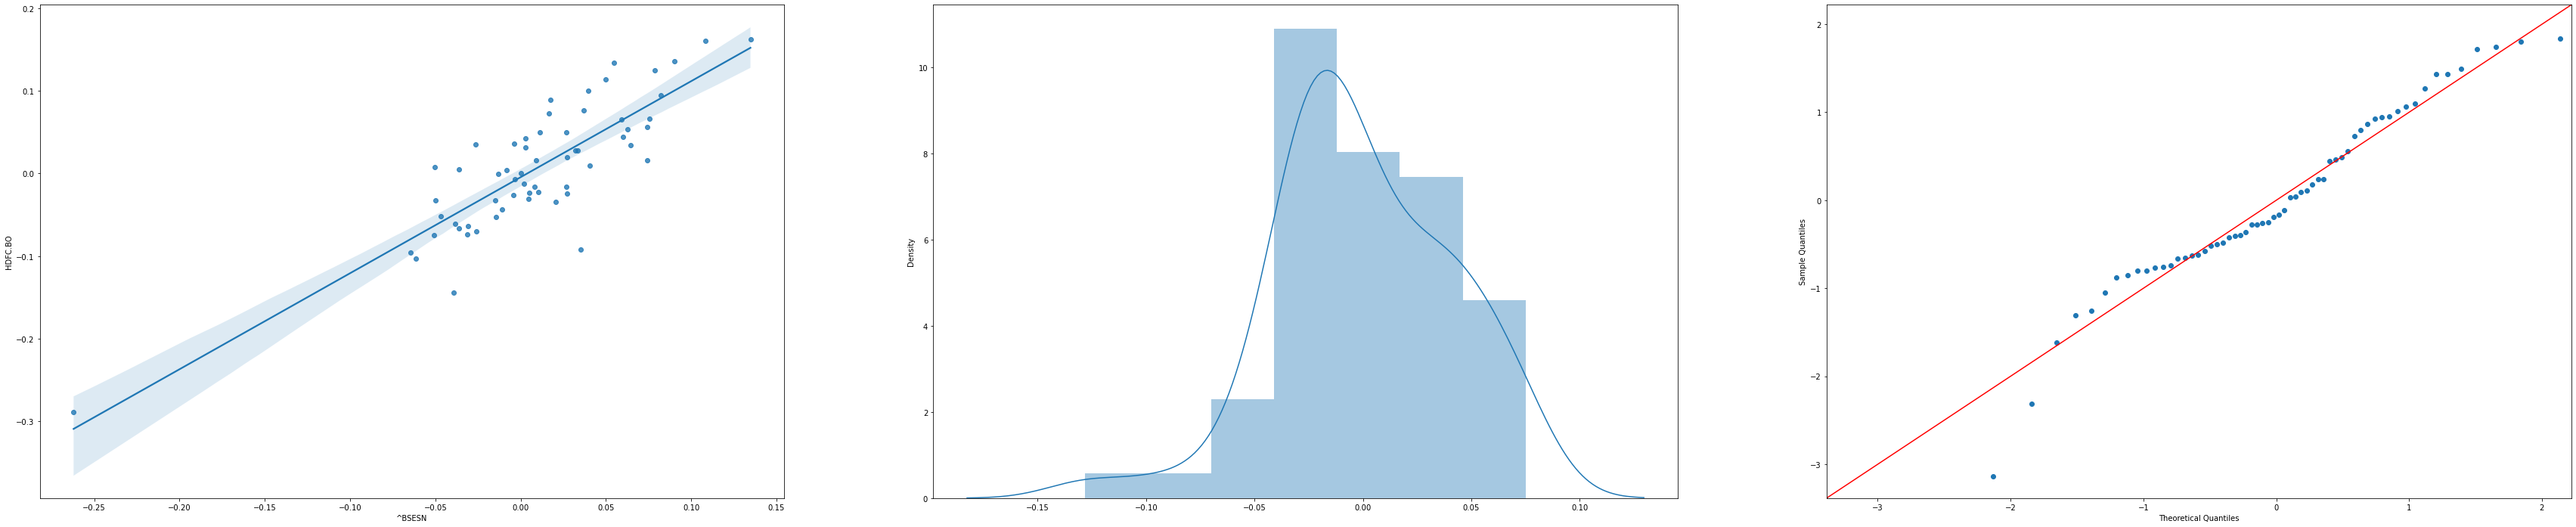

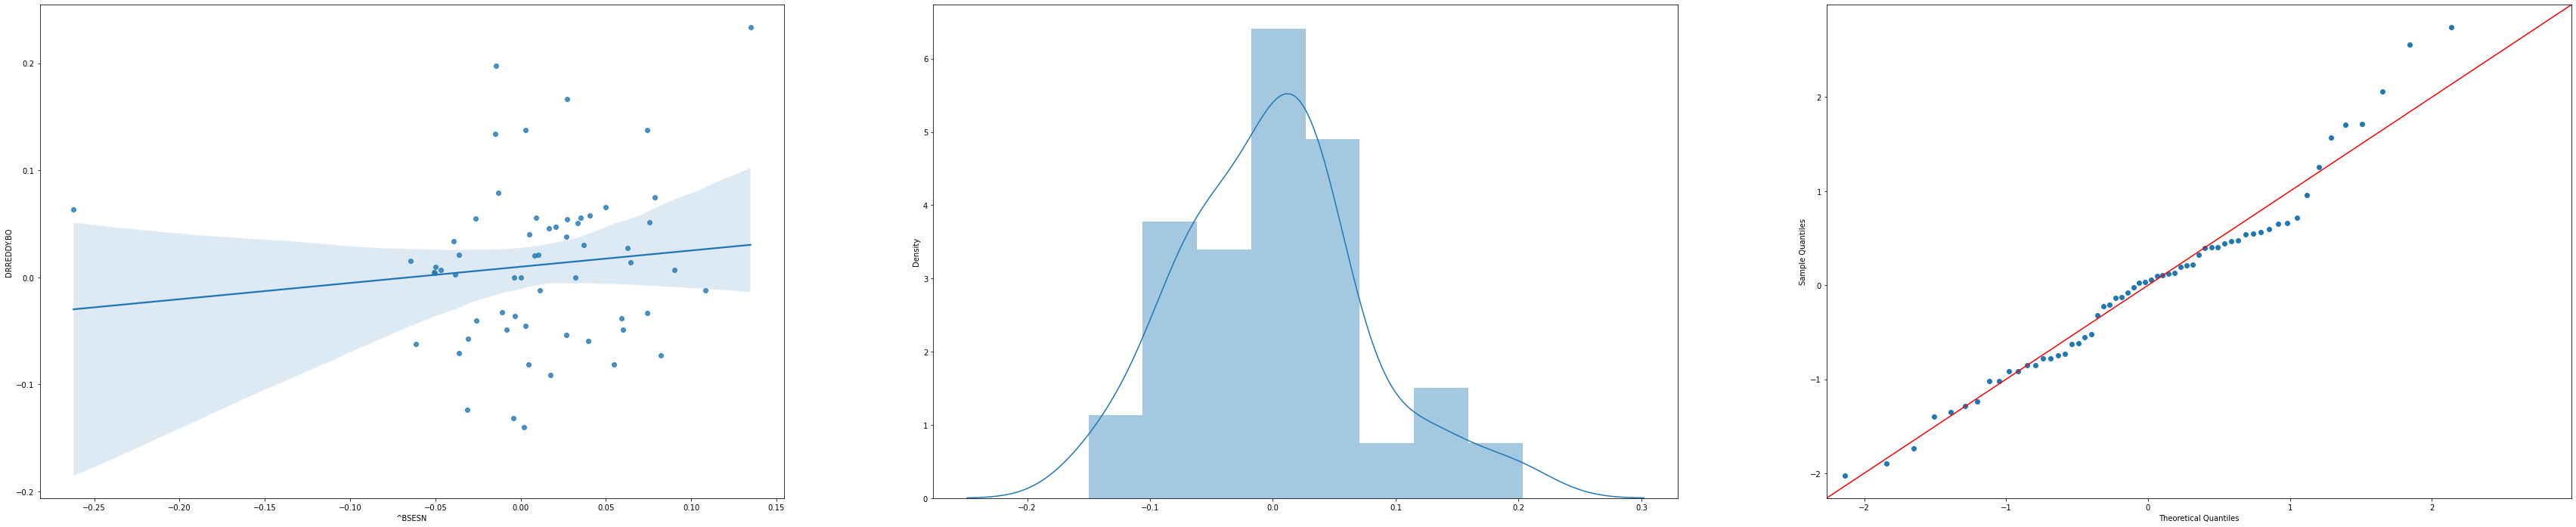

In [58]:
for ticker in tickers:
    if(ticker=="^BSESN"):
      continue

    linear_regression(ticker, "^BSESN")

print("\n------betas------")
print(beta_df)

print("\n------r squared scores------")
print(rsq_df)

print("\n------residue analysis------")
print(stats_df)

whitetest_df.rename(index={0:'Test Statistic', 1:'Test Statistic p-value', 2:'F-Statistic', 3:'F-Test p-value'}, inplace=True)
print("\n------white's test rsults------")
print(whitetest_df)


# Initializing risk free rate and finding market return

In [59]:
rm = log_returns['^BSESN'].mean() * 252
print("rm: "+str(rm))
rf=0.03
print("rf: "+str(rf))

rm: 2.443168098056949
rf: 0.03


# Calculating expected return, volatility and covariance of stocks

Expected return is calculated using the calculated betas according to CAPM model

In [60]:
er_capm = rf+(beta_df*(rm-rf))
er_capm
#er_capm=er_capm.drop(labels='^BSESN')
#er_capm

ADANIPORTS.BO    3.026162
MRF.BO           1.314535
TCS.BO           1.443004
RELIANCE.BO      2.405413
HDFC.BO          2.834267
DRREDDY.BO       0.396243
dtype: float64

calculating covariance matrix (excluding BSESN market index)

In [61]:
log_ret=log_returns.drop(columns="^BSESN")
cov=log_ret.cov()

# **CASE 1**
no short selling, no riskless borrowing/lending

initializing number of random portfolios, utility function coefficients and other variables.

In [62]:
num_ports = 15000

Util=np.zeros(num_ports)   # Empty list to store utility function values
A=4       # Risk Aversion factor
max_util_ret=0
max_util_risk=0

loop to calculate returns and volatility of random weighted portfolios

In [63]:
np.random.seed(101)
num_ports = 15000
all_weights = np.zeros((num_ports,n))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(n))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum(er_capm*weights)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(cov * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = (ret_arr[ind]-rf)/vol_arr[ind]
    
    #calculating utility values for this random portfolio's return and volatility
    Util[ind]=(ret_arr[ind]-0.5*A*vol_arr[ind]**2)
    if Util[ind]>=max(Util):
        max_util_ret=ret_arr[ind]
        max_util_risk=vol_arr[ind]
    
    

Finding MVP and Maximum Utility portfolio

In [64]:
# To find Minimum Variance and corresponding returns
min_vol_port = vol_arr.min()  
ind=np.argmin(vol_arr)  #index of minimum volitality

In [65]:
print("Maximum Utility function:",max(Util))
print("Return corresponding to Maximum Utility:",max_util_ret)
print("Risk corresponding to Maximum Utility:",max_util_risk)

Maximum Utility function: 1.0871125768492693
Return corresponding to Maximum Utility: 2.355822652654227
Risk corresponding to Maximum Utility: 0.796464084502546


Generating values to plot utility function

In [66]:
risk=np.linspace(vol_arr.min(),vol_arr.max(),50)
print(risk)

[0.67510424 0.68572145 0.69633867 0.70695588 0.71757309 0.72819031
 0.73880752 0.74942473 0.76004194 0.77065916 0.78127637 0.79189358
 0.8025108  0.81312801 0.82374522 0.83436244 0.84497965 0.85559686
 0.86621407 0.87683129 0.8874485  0.89806571 0.90868293 0.91930014
 0.92991735 0.94053456 0.95115178 0.96176899 0.9723862  0.98300342
 0.99362063 1.00423784 1.01485506 1.02547227 1.03608948 1.04670669
 1.05732391 1.06794112 1.07855833 1.08917555 1.09979276 1.11040997
 1.12102718 1.1316444  1.14226161 1.15287882 1.16349604 1.17411325
 1.18473046 1.19534768]


In [67]:
exp_ret=max(Util)+0.5*4*risk**2
exp_ret

array([1.99864405, 2.0275404 , 2.05688765, 2.08668581, 2.11693486,
       2.14763482, 2.17878568, 2.21038743, 2.24244009, 2.27494365,
       2.30789811, 2.34130347, 2.37515973, 2.4094669 , 2.44422496,
       2.47943392, 2.51509379, 2.55120455, 2.58776622, 2.62477879,
       2.66224226, 2.70015663, 2.7385219 , 2.77733807, 2.81660514,
       2.85632311, 2.89649198, 2.93711176, 2.97818243, 3.01970401,
       3.06167649, 3.10409986, 3.14697414, 3.19029932, 3.2340754 ,
       3.27830238, 3.32298027, 3.36810905, 3.41368873, 3.45971932,
       3.5062008 , 3.55313319, 3.60051647, 3.64835066, 3.69663575,
       3.74537174, 3.79455863, 3.84419642, 3.89428511, 3.94482471])

### Plots

(0.8, 2.0, 1.0, 3.0)

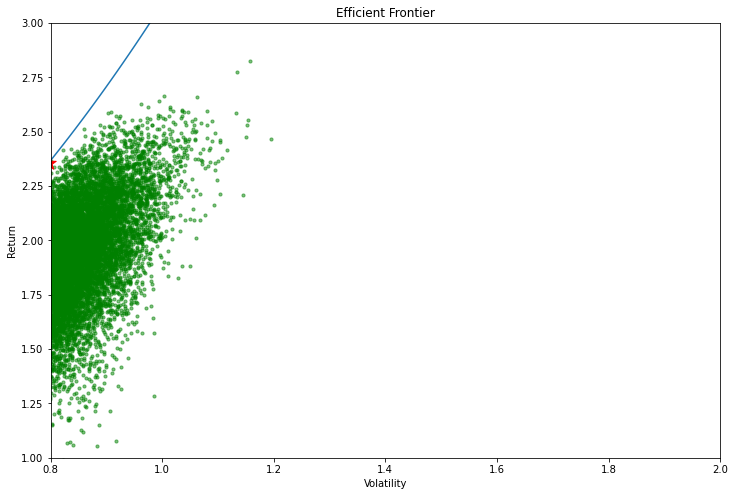

In [68]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,marker = 'o' , s = 10 ,alpha = 0.5 , color = 'green' )
plt.plot(risk,exp_ret)
plt.scatter(max_util_risk,max_util_ret,color='r',s=200,marker='*')
plt.scatter(min_vol_port,ret_arr[ind],color='b',s=200)
plt.title("Efficient Frontier")
plt.xlabel('Volatility')
plt.ylabel('Return')
x_min=0.8
x_max=2 
y_min=1
y_max=3
plt.axis([x_min, x_max, y_min, y_max])

#**CASE 2**

with short selling allowed and riskless lending/borrowing

We repeat the process of generating randomly weighted portfolios with the difference that now NEGATIVE WEIGHTS for stocks are also allowed (due to short selling being allowed)

In [69]:
num_ports = 15000
Util=np.zeros(num_ports)  # Empty list to store utility function values
A=4       # Risk Aversion factor
max_util_ret=0
max_util_risk=0

In [70]:
np.random.seed(101)
num_ports = 15000
all_weights = np.zeros((num_ports,n))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
ind=0
while ind < num_ports :

    # Create Random Weights
    weights = np.array(np.random.randint(-5000,5000,n))

    if np.sum(weights)==0 :
          continue

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum(er_capm*weights)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(cov * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = (ret_arr[ind]-rf)/vol_arr[ind]
    
    Util[ind]=ret_arr[ind]-0.5*A*vol_arr[ind]**2
    if Util[ind]>=max(Util):
        max_util_ret=ret_arr[ind]
        max_util_risk=vol_arr[ind]
    
    ind+=1

In [71]:
# To find Minimum Variance and corresponding returns
#ret_arr=ret_arr[np.logical_not(np.isnan(vol_arr))]
#Util=Util[np.logical_not(np.isnan(vol_arr))]
#vol_arr=vol_arr[np.logical_not(np.isnan(vol_arr))]
min_vol_port = vol_arr.min()  
ind=np.argmin(vol_arr)  #index of minimum volitality
vol_arr.min()

0.6775455270505177

In [72]:
print("Maximum Utility function:",max(Util))
print("Return corresponding to Maximum Utility:",max_util_ret)
print("Risk corresponding to Maximum Utility:",max_util_risk)

Maximum Utility function: 1.185377408825491
Return corresponding to Maximum Utility: 2.893789253288209
Risk corresponding to Maximum Utility: 0.9242326126205237


In [73]:
risk=np.linspace(vol_arr.min(),vol_arr.max(),50)
print(risk)

[6.77545527e-01 5.68308137e+01 1.12984082e+02 1.69137350e+02
 2.25290618e+02 2.81443886e+02 3.37597154e+02 3.93750423e+02
 4.49903691e+02 5.06056959e+02 5.62210227e+02 6.18363495e+02
 6.74516763e+02 7.30670031e+02 7.86823300e+02 8.42976568e+02
 8.99129836e+02 9.55283104e+02 1.01143637e+03 1.06758964e+03
 1.12374291e+03 1.17989618e+03 1.23604944e+03 1.29220271e+03
 1.34835598e+03 1.40450925e+03 1.46066252e+03 1.51681579e+03
 1.57296905e+03 1.62912232e+03 1.68527559e+03 1.74142886e+03
 1.79758213e+03 1.85373539e+03 1.90988866e+03 1.96604193e+03
 2.02219520e+03 2.07834847e+03 2.13450173e+03 2.19065500e+03
 2.24680827e+03 2.30296154e+03 2.35911481e+03 2.41526808e+03
 2.47142134e+03 2.52757461e+03 2.58372788e+03 2.63988115e+03
 2.69603442e+03 2.75218768e+03]


In [74]:
exp_ret=max(Util)+0.5*4*risk**2
exp_ret

array([2.10351329e+00, 6.46066814e+03, 2.55319909e+04, 5.72160717e+04,
       1.01512911e+05, 1.58422508e+05, 2.27944863e+05, 3.10079976e+05,
       4.04827847e+05, 5.12188476e+05, 6.32161864e+05, 7.64748009e+05,
       9.09946913e+05, 1.06775857e+06, 1.23818299e+06, 1.42122017e+06,
       1.61687011e+06, 1.82513280e+06, 2.04600825e+06, 2.27949647e+06,
       2.52559743e+06, 2.78431116e+06, 3.05563764e+06, 3.33957689e+06,
       3.63612889e+06, 3.94529365e+06, 4.26707116e+06, 4.60146144e+06,
       4.94846447e+06, 5.30808026e+06, 5.68030881e+06, 6.06515012e+06,
       6.46260419e+06, 6.87267101e+06, 7.29535059e+06, 7.73064293e+06,
       8.17854803e+06, 8.63906588e+06, 9.11219650e+06, 9.59793987e+06,
       1.00962960e+07, 1.06072649e+07, 1.11308465e+07, 1.16670409e+07,
       1.22158481e+07, 1.27772680e+07, 1.33513007e+07, 1.39379461e+07,
       1.45372043e+07, 1.51490753e+07])

For finding optimal portfolio/tangency portfolio, we maximize the sharpe ratio. Or rather, here, we find the portfolio corresponding to maximum sharpe ratio.

In [75]:
# Finding the optimal portfolio : Highest SHARPE RATIO
optimal_risky_port_max = sharpe_arr.max()
index_max_sharpe=np.argmax(sharpe_arr)
max_sharpe_exp_ret = ret_arr[index_max_sharpe]
max_sharpe_vol = vol_arr[index_max_sharpe]

here we generate the values for plotting the CML

In [76]:
slope=(max_sharpe_exp_ret-rf)/max_sharpe_vol
x_rf = np.linspace(0,vol_arr.max(),4)
y_rf = (slope)*x_rf+rf

plots

(0.0, 13.0, 0.0, 20.0)

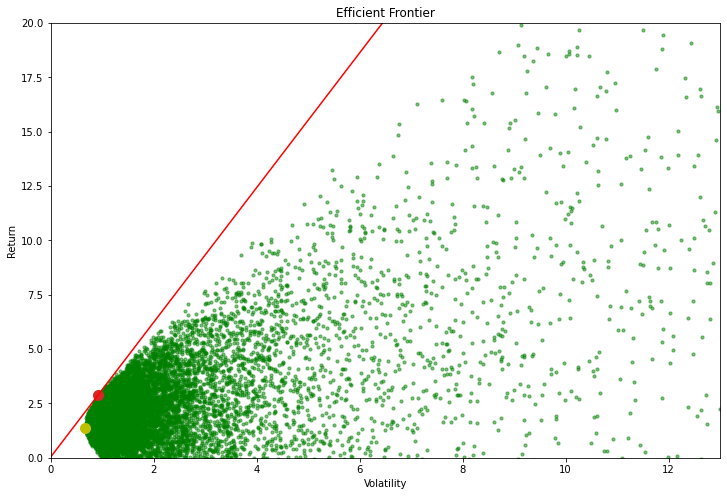

In [77]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,marker = 'o' , s = 10 ,alpha = 0.5 , color = 'green' )
plt.scatter(max_sharpe_vol,max_sharpe_exp_ret,color='#d62728',s=100)
plt.scatter(min_vol_port,ret_arr[ind],color='y',s=100)
plt.plot(x_rf, y_rf, '-r', label='lending-borrowing')
#plt.plot(risk,exp_ret)
plt.title("Efficient Frontier")
plt.xlabel('Volatility')
plt.ylabel('Return')
x_min=0
x_max=13 
y_min=0
y_max=20
plt.axis([x_min, x_max, y_min, y_max])